In [2]:
import sys
import os

root_dir = os.path.abspath("/Users/ryant/Documents/Github/digital-asset-options-pricing")
if root_dir not in sys.path:
    sys.path.append(root_dir)
os.chdir(root_dir)

In [3]:
# from src.pricer import MCEuropeanPricer, AnalyticEuropeanPricer, BinomialEuropeanPricer, FdBlackScholesVanillaPricer

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

In [3]:
df = pd.read_parquet('/Users/ryant/Documents/Github/digital-asset-options-pricing/src/data/deribit/data/deribit_btc_snapshot_011124_301124.parquet')
df.head(5)

,date,open_interest,underlyer,expiration_date,claim_type,mark_price,mark_iv,bid_iv,ask_iv,exercise,settlement,strike,best_bid_price,best_ask_price,underlyer_spot,forward_price,volume,best_ask_amount,best_bid_amount,instrument_name
0,1730419200000,107.7,BTC_USD,2024-11-08T08:00:00.000Z,put,0.0810,68.41,66.03,72.38,European,cash,75000,0.0800,0.0830,70190.9,70373.62,9.0,7.8,6.6,BTC-8NOV24-75000-P
1,1730419200000,2378.0,BTC_USD,2024-11-08T08:00:00.000Z,call,0.0154,68.41,68.68,69.74,European,cash,75000,0.0155,0.0160,70190.9,70373.62,265.5,33.5,0.1,BTC-8NOV24-75000-C
2,1730419200000,97.5,BTC_USD,2024-11-08T08:00:00.000Z,put,0.0704,68.11,65.16,72.07,European,cash,74000,0.0690,0.0725,70190.9,70373.62,25.0,17.6,25.0,BTC-8NOV24-74000-P
3,1730419200000,531.4,BTC_USD,2024-11-08T08:00:00.000Z,call,0.0190,68.11,67.22,69.19,European,cash,74000,0.0185,0.0195,70190.9,70373.62,148.8,23.0,58.6,BTC-8NOV24-74000-C
4,1730419200000,174.3,BTC_USD,2024-11-08T08:00:00.000Z,put,0.0606,68.05,66.87,69.67,European,cash,73000,0.0595,0.0615,70190.9,70373.62,23.7,26.6,26.1,BTC-8NOV24-73000-P


In [4]:
df['expiration_date']

0          2024-11-08T08:00:00.000Z
1          2024-11-08T08:00:00.000Z
2          2024-11-08T08:00:00.000Z
3          2024-11-08T08:00:00.000Z
4          2024-11-08T08:00:00.000Z
                     ...           
2455853    2025-09-26T08:00:00.000Z
2455854    2025-09-26T08:00:00.000Z
2455855    2025-09-26T08:00:00.000Z
2455856    2025-09-26T08:00:00.000Z
2455857    2025-09-26T08:00:00.000Z
Name: expiration_date, Length: 2455858, dtype: object

In [ ]:
# Note that Deribit BTC Contract size is 1 BTC
# https://www.deribit.com/kb/linear_usdc_options
df_options = df.copy()
df_options = df_options[['date', 'instrument_name', 'expiration_date', 'strike', 'claim_type', 'underlyer_spot', 'best_bid_price', 'best_ask_price', ]]

df_options['datetime'] = pd.to_datetime(df_options['date'], unit='ms', utc=True)
df_options['hour'] = df_options.datetime.dt.hour
df_options['minute'] = df_options.datetime.dt.hour
df_options['days_to_expiry'] = (pd.to_datetime(df_options['expiration_date'], utc=True) - df_options['datetime']).dt.days
df_options = df_options.merge(df_options.datetime.dt.isocalendar(), left_index=True, right_index=True)
df_options['month'] = df_options.datetime.dt.month
# Extract day of week for expiration (0=Monday, 6=Sunday)
df_options['expiration_date'] = pd.to_datetime(df_options['expiration_date'], utc=True)
df_options['expiry_dow'] = df_options['expiration_date'].dt.dayofweek  # 4 = Friday

# Determine if it's the last Friday of the month
# Get the last day of each expiration month
df_options['last_day_of_month'] = df_options['expiration_date'].dt.to_period('M').dt.to_timestamp('M')
# Move backward to find the last Friday (weekday 4)
df_options['last_friday'] = df_options.apply(
    lambda x: x['last_day_of_month'] - pd.Timedelta(days=((x['last_day_of_month'].dayofweek - 4) % 7)), 
    axis=1
)

# Determine the month number for quarterly calculation (1=Jan, 2=Feb, etc.)
df_options['expiry_month'] = df_options['expiration_date'].dt.month

# Create the classification columns
# Daily options: expire every day at 08:00 UTC
df_options['is_daily'] = ((df_options['expiration_date'].dt.hour == 8) & \
                         (df_options['expiration_date'].dt.minute == 0)).astype(int)

# Weekly options: expire on each Friday at 08:00 UTC
df_options['is_weekly'] = ((df_options['expiry_dow'] == 4) & \
                         (df_options['expiration_date'].dt.hour == 8) & \
                         (df_options['expiration_date'].dt.minute == 0) & \
                         (df_options['expiration_date'] != df_options['last_friday'])).astype(int)

# Monthly options: expire on the last Friday of each calendar month at 08:00 UTC
df_options['is_monthly'] = ((df_options['expiration_date'] == df_options['last_friday']) & \
                          (df_options['expiration_date'].dt.hour == 8) & \
                          (df_options['expiration_date'].dt.minute == 0) & \
                          (~df_options['expiry_month'].isin([3, 6, 9, 12]))).astype(int)

# Quarterly options: expire on the last Friday of each calendar quarter at 08:00 UTC
df_options['is_quarterly'] = ((df_options['expiration_date'] == df_options['last_friday']) & \
                            (df_options['expiration_date'].dt.hour == 8) & \
                            (df_options['expiration_date'].dt.minute == 0) & \
                            (df_options['expiry_month'].isin([3, 6, 9, 12]))).astype(int)

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_24476/4287985767.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_options['last_day_of_month'] = df_options['expiration_date'].dt.to_period('M').dt.to_timestamp('M')


,date,instrument_name,expiration_date,strike,claim_type,underlyer_spot,best_bid_price,best_ask_price,datetime,hour,...,day,month,expiry_dow,last_day_of_month,last_friday,expiry_month,is_daily,is_weekly,is_monthly,is_quarterly
0,1730419200000,BTC-8NOV24-75000-P,2024-11-08 08:00:00+00:00,75000,put,70190.90,0.0800,0.0830,2024-11-01 00:00:00+00:00,0,...,5,11,4,2024-11-30,2024-11-29,11,1,1,0,0
1,1730419200000,BTC-8NOV24-75000-C,2024-11-08 08:00:00+00:00,75000,call,70190.90,0.0155,0.0160,2024-11-01 00:00:00+00:00,0,...,5,11,4,2024-11-30,2024-11-29,11,1,1,0,0
2,1730419200000,BTC-8NOV24-74000-P,2024-11-08 08:00:00+00:00,74000,put,70190.90,0.0690,0.0725,2024-11-01 00:00:00+00:00,0,...,5,11,4,2024-11-30,2024-11-29,11,1,1,0,0
3,1730419200000,BTC-8NOV24-74000-C,2024-11-08 08:00:00+00:00,74000,call,70190.90,0.0185,0.0195,2024-11-01 00:00:00+00:00,0,...,5,11,4,2024-11-30,2024-11-29,11,1,1,0,0
4,1730419200000,BTC-8NOV24-73000-P,2024-11-08 08:00:00+00:00,73000,put,70190.90,0.0595,0.0615,2024-11-01 00:00:00+00:00,0,...,5,11,4,2024-11-30,2024-11-29,11,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455853,1733010300000,BTC-26SEP25-110000-C,2025-09-26 08:00:00+00:00,110000,call,96514.72,0.2010,0.2070,2024-11-30 23:45:00+00:00,23,...,6,11,4,2025-09-30,2025-09-26,9,1,1,0,0
2455854,1733010300000,BTC-26SEP25-105000-P,2025-09-26 08:00:00+00:00,105000,put,96514.72,0.1965,0.2085,2024-11-30 23:45:00+00:00,23,...,6,11,4,2025-09-30,2025-09-26,9,1,1,0,0
2455855,1733010300000,BTC-26SEP25-105000-C,2025-09-26 08:00:00+00:00,105000,call,96514.72,0.2175,0.2245,2024-11-30 23:45:00+00:00,23,...,6,11,4,2025-09-30,2025-09-26,9,1,1,0,0
2455856,1733010300000,BTC-26SEP25-100000-P,2025-09-26 08:00:00+00:00,100000,put,96514.72,0.1730,0.1790,2024-11-30 23:45:00+00:00,23,...,6,11,4,2025-09-30,2025-09-26,9,1,1,0,0


In [31]:
df_options['price_spread'] = df_options['best_ask_price'] - df_options['best_bid_price']
df_options

,date,instrument_name,expiration_date,strike,claim_type,underlyer_spot,best_bid_price,best_ask_price,datetime,hour,...,month,expiry_dow,last_day_of_month,last_friday,expiry_month,is_daily,is_weekly,is_monthly,is_quarterly,price_spread
0,1730419200000,BTC-8NOV24-75000-P,2024-11-08 08:00:00+00:00,75000,put,70190.90,0.0800,0.0830,2024-11-01 00:00:00+00:00,0,...,11,4,2024-11-30,2024-11-29,11,1,1,0,0,0.0030
1,1730419200000,BTC-8NOV24-75000-C,2024-11-08 08:00:00+00:00,75000,call,70190.90,0.0155,0.0160,2024-11-01 00:00:00+00:00,0,...,11,4,2024-11-30,2024-11-29,11,1,1,0,0,0.0005
2,1730419200000,BTC-8NOV24-74000-P,2024-11-08 08:00:00+00:00,74000,put,70190.90,0.0690,0.0725,2024-11-01 00:00:00+00:00,0,...,11,4,2024-11-30,2024-11-29,11,1,1,0,0,0.0035
3,1730419200000,BTC-8NOV24-74000-C,2024-11-08 08:00:00+00:00,74000,call,70190.90,0.0185,0.0195,2024-11-01 00:00:00+00:00,0,...,11,4,2024-11-30,2024-11-29,11,1,1,0,0,0.0010
4,1730419200000,BTC-8NOV24-73000-P,2024-11-08 08:00:00+00:00,73000,put,70190.90,0.0595,0.0615,2024-11-01 00:00:00+00:00,0,...,11,4,2024-11-30,2024-11-29,11,1,1,0,0,0.0020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455853,1733010300000,BTC-26SEP25-110000-C,2025-09-26 08:00:00+00:00,110000,call,96514.72,0.2010,0.2070,2024-11-30 23:45:00+00:00,23,...,11,4,2025-09-30,2025-09-26,9,1,1,0,0,0.0060
2455854,1733010300000,BTC-26SEP25-105000-P,2025-09-26 08:00:00+00:00,105000,put,96514.72,0.1965,0.2085,2024-11-30 23:45:00+00:00,23,...,11,4,2025-09-30,2025-09-26,9,1,1,0,0,0.0120
2455855,1733010300000,BTC-26SEP25-105000-C,2025-09-26 08:00:00+00:00,105000,call,96514.72,0.2175,0.2245,2024-11-30 23:45:00+00:00,23,...,11,4,2025-09-30,2025-09-26,9,1,1,0,0,0.0070
2455856,1733010300000,BTC-26SEP25-100000-P,2025-09-26 08:00:00+00:00,100000,put,96514.72,0.1730,0.1790,2024-11-30 23:45:00+00:00,23,...,11,4,2025-09-30,2025-09-26,9,1,1,0,0,0.0060


In [32]:
df_options_daily = df_options[(df_options['hour'] == 0) & (df_options['minute'] == 0)]
df_options_daily

,date,instrument_name,expiration_date,strike,claim_type,underlyer_spot,best_bid_price,best_ask_price,datetime,hour,...,month,expiry_dow,last_day_of_month,last_friday,expiry_month,is_daily,is_weekly,is_monthly,is_quarterly,price_spread
0,1730419200000,BTC-8NOV24-75000-P,2024-11-08 08:00:00+00:00,75000,put,70190.90,0.0800,0.0830,2024-11-01 00:00:00+00:00,0,...,11,4,2024-11-30,2024-11-29,11,1,1,0,0,0.0030
1,1730419200000,BTC-8NOV24-75000-C,2024-11-08 08:00:00+00:00,75000,call,70190.90,0.0155,0.0160,2024-11-01 00:00:00+00:00,0,...,11,4,2024-11-30,2024-11-29,11,1,1,0,0,0.0005
2,1730419200000,BTC-8NOV24-74000-P,2024-11-08 08:00:00+00:00,74000,put,70190.90,0.0690,0.0725,2024-11-01 00:00:00+00:00,0,...,11,4,2024-11-30,2024-11-29,11,1,1,0,0,0.0035
3,1730419200000,BTC-8NOV24-74000-C,2024-11-08 08:00:00+00:00,74000,call,70190.90,0.0185,0.0195,2024-11-01 00:00:00+00:00,0,...,11,4,2024-11-30,2024-11-29,11,1,1,0,0,0.0010
4,1730419200000,BTC-8NOV24-73000-P,2024-11-08 08:00:00+00:00,73000,put,70190.90,0.0595,0.0615,2024-11-01 00:00:00+00:00,0,...,11,4,2024-11-30,2024-11-29,11,1,1,0,0,0.0020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2379805,1732927500000,BTC-26SEP25-110000-C,2025-09-26 08:00:00+00:00,110000,call,97065.83,0.2035,0.2090,2024-11-30 00:45:00+00:00,0,...,11,4,2025-09-30,2025-09-26,9,1,1,0,0,0.0055
2379806,1732927500000,BTC-26SEP25-105000-P,2025-09-26 08:00:00+00:00,105000,put,97065.83,0.1935,0.2050,2024-11-30 00:45:00+00:00,0,...,11,4,2025-09-30,2025-09-26,9,1,1,0,0,0.0115
2379807,1732927500000,BTC-26SEP25-105000-C,2025-09-26 08:00:00+00:00,105000,call,97064.19,0.2205,0.2265,2024-11-30 00:45:00+00:00,0,...,11,4,2025-09-30,2025-09-26,9,1,1,0,0,0.0060
2379808,1732927500000,BTC-26SEP25-100000-P,2025-09-26 08:00:00+00:00,100000,put,97065.83,0.1705,0.1770,2024-11-30 00:45:00+00:00,0,...,11,4,2025-09-30,2025-09-26,9,1,1,0,0,0.0065


In [19]:
spot_price = pd.DataFrame(df_options.groupby('datetime')['underlyer_spot'].mean()).reset_index()
spot_price

,datetime,underlyer_spot
0,2024-11-01 00:00:00+00:00,70190.197235
1,2024-11-01 00:15:00+00:00,70325.500000
2,2024-11-01 00:30:00+00:00,70315.591382
3,2024-11-01 00:45:00+00:00,70139.588710
4,2024-11-01 01:00:00+00:00,70073.180000
...,...,...
2807,2024-11-30 22:45:00+00:00,96654.575046
2808,2024-11-30 23:00:00+00:00,96531.203333
2809,2024-11-30 23:15:00+00:00,96516.829120
2810,2024-11-30 23:30:00+00:00,96409.206736


# Data Visualization

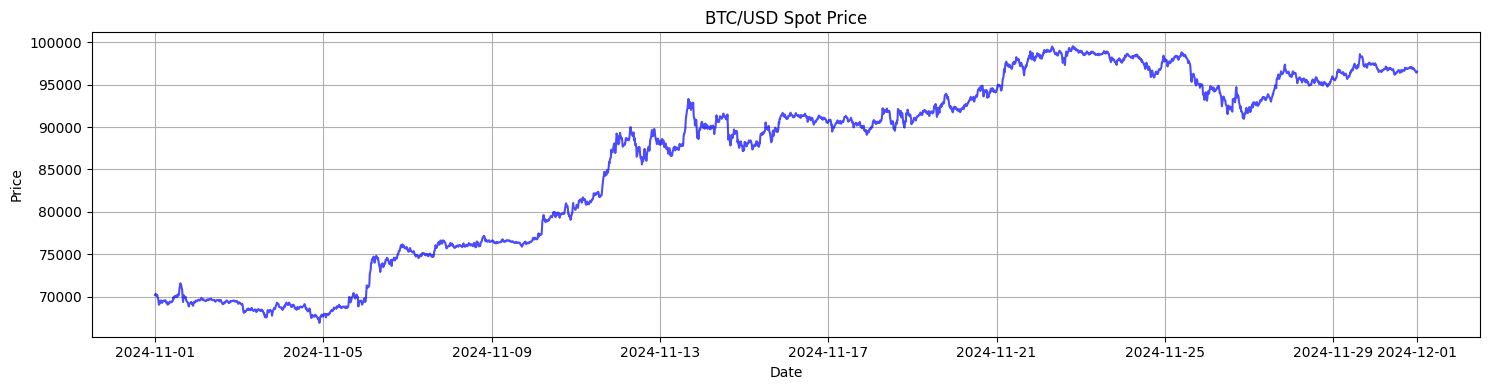

In [27]:
def plot_data(x, y, title=None, xlabel=None, ylabel=None, figsize=(10, 6), 
              color='blue', marker=None, linestyle='-', alpha=0.7, 
              grid=True,):
    """
    Generic function to plot x vs y data using matplotlib.
    
    Parameters:
    -----------
    marker : str, optional
        Marker style (e.g., 'o', '.', 's', None)
    linestyle : str, optional
        Line style (e.g., '-', '--', ':', '-.')
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the data
    ax.plot(x, y, color=color, marker=marker, linestyle=linestyle, alpha=alpha)
    
    # Set title and labels if provided
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    
    # Add grid if requested
    ax.grid(grid)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_data(spot_price['datetime'], spot_price['underlyer_spot'], title='BTC/USD Spot Price', linestyle = '-', xlabel='Date', ylabel='Price', figsize=(15,4))

Removed 117 outliers (0.23%) outside 3 standard deviations
Removed 1906 outliers (3.71%) outside 3 standard deviations


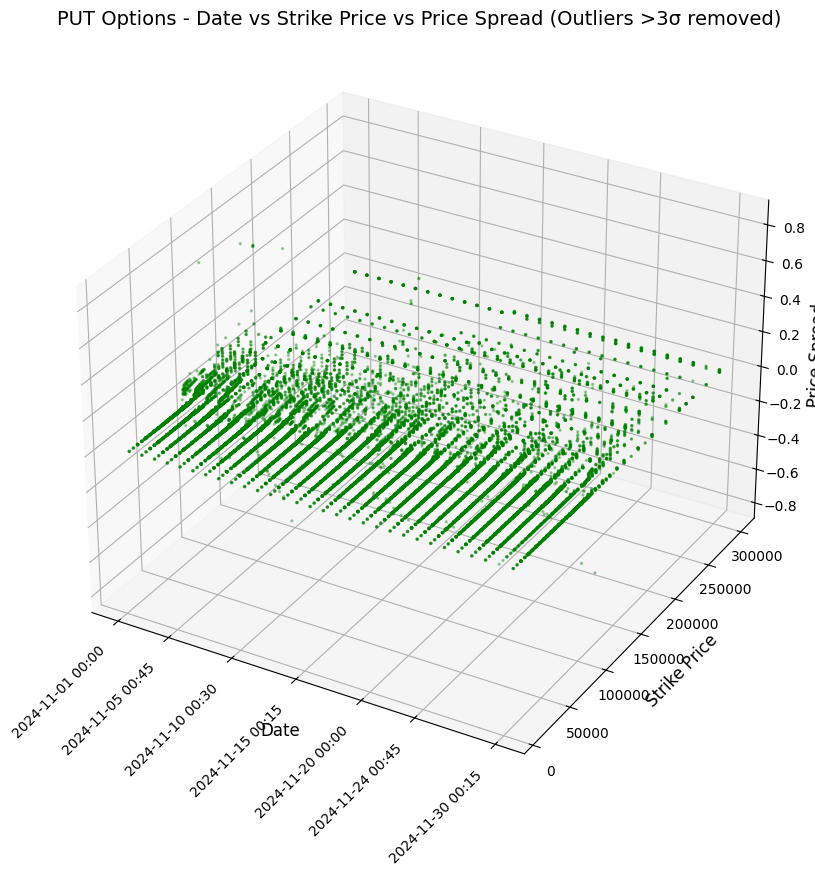

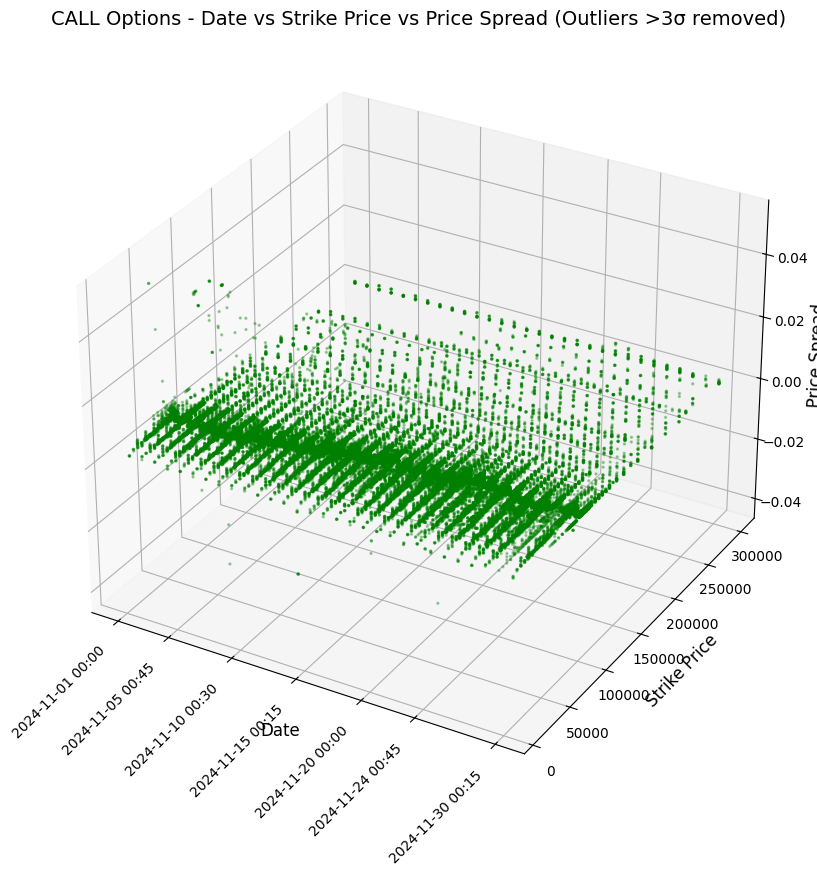

In [61]:
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as colors


def plot_options_3d(df_options_daily, option_type=None, std_dev_threshold=3):
    """
    Creates 3D plots for options data with date on x-axis,
    strike on y-axis, and price_spread on z-axis.
    
    Parameters:
    -----------
    df_options_daily : pandas DataFrame
        DataFrame containing options data
    option_type : str, optional
        'put', 'call', or None (for both)
    std_dev_threshold : float, optional
        Number of standard deviations to use for outlier removal
    
    Returns:
    --------
    None
    """    
    # Make a copy to avoid modifying the original dataframe
    df = df_options_daily.copy()
    
    # Convert datetime to numeric for plotting
    if isinstance(df['datetime'].iloc[0], str):
        df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Convert to timestamp for numerical representation
    df['datetime_num'] = df['datetime'].astype(np.int64) // 10**9
    
    # Filter the data based on option_type
    if option_type == 'put':
        data_to_plot = [df[df['claim_type'] == 'put']]
        titles = ['PUT Options']
    elif option_type == 'call':
        data_to_plot = [df[df['claim_type'] == 'call']]
        titles = ['CALL Options']
    else:  # Plot both
        data_to_plot = [df[df['claim_type'] == 'put'], df[df['claim_type'] == 'call']]
        titles = ['PUT Options', 'CALL Options']
    
    # Define formatter for date axis
    def format_date(x, pos=None):
        return pd.to_datetime(x, unit='s').strftime('%Y-%m-%d %H:%M')
    
    # Create custom colormap: red for negative, green for positive
    custom_cmap = colors.ListedColormap(['red', 'green'])
    custom_norm = colors.BoundaryNorm([float('-inf'), 0, float('inf')], custom_cmap.N)
    
    # Plot each dataset
    for data, title in zip(data_to_plot, titles):
        if data.empty:
            continue
        
        # Remove outliers based on price_spread
        mean = data['price_spread'].mean()
        std = data['price_spread'].std()
        lower_bound = mean - std_dev_threshold * std
        upper_bound = mean + std_dev_threshold * std
        
        # Filter data within bounds
        filtered_data = data[(data['price_spread'] >= lower_bound) & 
                             (data['price_spread'] <= upper_bound)]
        
        # Log how many outliers were removed
        outliers_count = len(data) - len(filtered_data)
        outlier_percentage = (outliers_count / len(data)) * 100 if len(data) > 0 else 0
        print(f"Removed {outliers_count} outliers ({outlier_percentage:.2f}%) outside {std_dev_threshold} standard deviations")
        
        # Use the filtered data
        data = filtered_data
        
        if data.empty:
            print(f"No data left after outlier removal for {title}")
            continue
        
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Fixed axis configuration (date on x, strike on y, price_spread on z)
        x_data = data['datetime_num']
        y_data = data['strike']
        z_data = data['price_spread']
        
        x_label = 'Date'
        y_label = 'Strike Price'
        z_label = 'Price Spread'
        
        # Format the x-axis (date) with custom formatter
        x_formatter = FuncFormatter(format_date)
        ax.xaxis.set_major_formatter(x_formatter)
        
        # Select a reasonable number of tick locations for dates
        unique_dates = sorted(data['datetime_num'].unique())
        if len(unique_dates) > 6:
            step = max(1, len(unique_dates) // 6)
            selected_dates = unique_dates[::step]
        else:
            selected_dates = unique_dates
        
        ax.set_xticks(selected_dates)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Create the scatter plot with red/green coloring
        scatter = ax.scatter(
            x_data, 
            y_data,
            z_data,
            c=(data['price_spread'] > 0).astype(int),  # 0 for negative, 1 for positive
            cmap=custom_cmap,
            norm=custom_norm,
            marker='o',
            alpha=0.3,
            s=2
        )
        
        # Customize the plot
        plot_title = f'{title} - {x_label} vs {y_label} vs {z_label} (Outliers >{std_dev_threshold}σ removed)'
        ax.set_title(plot_title, fontsize=14)
        ax.set_xlabel(x_label, fontsize=12)
        ax.set_ylabel(y_label, fontsize=12)
        ax.set_zlabel(z_label, fontsize=12)
        
        # Add color
# Plot only puts
plot_options_3d(df_options_daily, option_type='put')

# Plot only calls
plot_options_3d(df_options_daily, option_type='call')

# Plot with strike on z-axis and price_spread on y-axis
# plot_options_3d(df_options_daily, option_type='put', swap_axes=True)